In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/671/open-unmix-pytorch//"

/content/drive/My Drive/Colab Notebooks/671/open-unmix-pytorch


In [ ]:
%pip install gitpython

     |████████████████████████████████| 163kB 7.7MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 


In [ ]:
!pip install musdb
!sudo apt-get install sox libsox-dev libsox-fmt-all
!pip install git+git://github.com/pytorch/audio

     |████████████████████████████████| 512kB 11.4MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libmagic-mgc libmagic1
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-ao
  libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3
Suggested packages:
  libaudio2 file
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libmagic-mgc libmagic1
  libopencore-amrnb0 libopencore-amrwb0 libsox-dev libsox-fmt-all
  libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss
  libsox-fmt-pulse libsox3 sox
0 upgraded, 18 newly installed, 0 to remove and 14 not upgraded.
Need to get 1,267 kB of archives.
After this operation, 9,153 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [

In [ ]:
!pip install museval

     |████████████████████████████████| 133kB 12.0MB/s 


In [ ]:
# load model_default
from pathlib import Path
import json
import model
# import open_baseline as model
import open_uni_resume_1 as modified_model
import torch
import numpy as np

def bandwidth_to_max_bin(rate, n_fft, bandwidth):
    freqs = np.linspace(
        0, float(rate) / 2, n_fft // 2 + 1,
        endpoint=True
    )

    return np.max(np.where(freqs <= bandwidth)[0]) + 1

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

path_default = './open-unmix/default_train_20'
path_mel = './open-unmix/add_mel/done'
model_path = path_default

target = 'vocals'
with open(Path(model_path, target + '.json'), 'r') as stream:
  results = json.load(stream)


target_model_path = next(Path(model_path).glob("%s*.pth" % target))
state = torch.load(
            target_model_path,
            map_location=device
        )

max_bin = bandwidth_to_max_bin(
            state['sample_rate'],
            results['args']['nfft'],
            results['args']['bandwidth']
        )

unmix = model.OpenUnmix(
            n_fft=results['args']['nfft'],
            n_hop=results['args']['nhop'],
            nb_channels=results['args']['nb_channels'],
            hidden_size=results['args']['hidden_size'],
            max_bin=max_bin
        )


unmix.load_state_dict(state)
unmix.stft.center = True
# unmix.eval()
# unmix.to(device)

In [ ]:
# load model_mel
from pathlib import Path
import json
# import model
import open_uni_resume_1 as modified_model
import torch
import numpy as np

def bandwidth_to_max_bin(rate, n_fft, bandwidth):
    freqs = np.linspace(
        0, float(rate) / 2, n_fft // 2 + 1,
        endpoint=True
    )

    return np.max(np.where(freqs <= bandwidth)[0]) + 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

#path_default = './open-unmix/default_train_20'
path_mel = './open-unmix/add_mel/done'
model_path = path_mel

target = 'vocals'
with open(Path(model_path, target + '.json'), 'r') as stream:
  results = json.load(stream)
  print(results.keys())


target_model_path = next(Path(model_path).glob("%s*.pth" % target))
state = torch.load(
            target_model_path,
            map_location=device
        )

max_bin = bandwidth_to_max_bin( rate=44100, n_fft=4096, bandwidth = 16000
            #state['sample_rate'],
            #results['n_fft'],
            #results['bandwidth']
        )

unmix_mel = modified_model.OpenUnmix(
            n_fft=4096,
            n_hop=1024,#results['n_hop'],
            nb_channels=2,#results['nb_channels'],
            hidden_size=512,#results['hidden_size'],
            max_bin=max_bin
        )


unmix_mel.load_state_dict(state)
unmix_mel.stft.center = True
# unmix.eval()
#unmix_mel=unmix_mel.to(device)

dict_keys(['best_epoch', 'best_loss', 'epochs_trained', 'num_bad_epochs', 'train_loss_history', 'train_time_history', 'valid_loss_history'])


In [ ]:
# estimates
## estimate
import torch
import numpy as np
from scipy.signal import stft, istft

def estimate(track,unmix):
  # small epsilon to avoid dividing by zero
  eps = np.finfo(np.float).eps

  # compute STFT of Mixture
  N = track.audio.shape[0]  # remember number of samples for future use
  X = stft(track.audio.T, nperseg=4096, noverlap=3072)[-1]
  (I, F, T) = X.shape

  # Compute sources spectrograms
  P = {}
  # compute model as the sum of spectrograms
  model = eps

  for name, source in track.sources.items():
      #print(name)
      # compute spectrogram of target source:
      #unmix = torch.hub.load('./open-unmix/default_train_20', model='umx', target=name)
      
      P[name] = unmix(torch.tensor(track.audio.T[None, ...]).float()).detach().numpy()[:, 0, ...].transpose(1, 2, 0)
  #     P[name] = np.abs(stft(source.audio.T, nperseg=4096, noverlap=3072)[-1])
      model += P[name]

  # now performs separation
  estimates = {}
  for name, source in track.sources.items():
      # compute soft mask as the ratio between source spectrogram and total
      Mask = P[name] / model

      # multiply the mix by the mask
      Yj = Mask * X

      # invert to time domain
      target_estimate = istft(Yj, nperseg=4096, noverlap=3072)[1].T

      # set this as the source estimate
      estimates[name] = target_estimate
  return estimates



Done!


In [ ]:
# baseline model
import musdb
import museval

mus = musdb.DB(download=True, subsets='test')

results=museval.EvalStore(frames_agg='median',tracks_agg='median')
for track in mus:
  E = estimate(track,unmix)
  results.add_track(museval.eval_mus_track(track,E))

print(results)

In [ ]:
# Mel model
import musdb
import museval

# mus = musdb.DB(download=True, subsets='test')

results2=museval.EvalStore(frames_agg='median',tracks_agg='median')
for track in mus:
  E = estimate(track,unmix_mel)
  results2.add_track(museval.eval_mus_track(track,E))

print(results2)

Done!


/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm

In [ ]:
# for target, estimate in estimates.items():
from IPython.display import Audio, display
track = mus[1]
print(track.name)
E = estimate(track,unmix)
E2 = estimate(track,unmix_mel)


display(Audio(E['vocals'].T, rate=track.rate))
display(Audio(E2['vocals'].T, rate=track.rate))

In [ ]:
# for target, estimate in estimates.items():
from IPython.display import Audio, display

track = mus[5]
print(track.name)
E = estimate(track,unmix)
E2 = estimate(track,unmix_mel)

display(Audio(track.audio.T, rate=track.rate))
display(Audio(E['vocals'].T, rate=track.rate))
display(Audio(E2['vocals'].T, rate=track.rate))


BKS - Too Much
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])
lstm_out2 shape torch.Size([294, 1, 512])
lstm_out shape torch.Size([294, 1, 512])


In [ ]:
#museval.eval_mus_track(track,E).df

In [ ]:
results=museval.EvalStore(frames_agg='median',tracks_agg='median')
for track in mus:
  results.add_track(museval.eval_mus_track(track,total[track.name]))

In [ ]:
print(results)

Aggrated Scores (median over frames, median over tracks)
vocals          ==> SDR:   1.877  SIR:   0.896  ISR:   2.389  SAR:   4.886  
drums           ==> SDR:   0.028  SIR:  -9.451  ISR:   0.733  SAR:   4.396  
bass            ==> SDR:  -0.255  SIR: -11.828  ISR:   0.623  SAR:   4.881  
other           ==> SDR:   0.749  SIR:  -4.327  ISR:   1.613  SAR:   4.850  



In [ ]:
import pandas as pd

# A = total['Al James - Schoolboy Facination']#['vocals']
# T = mus[0]
# track_scores = museval.eval_mus_track(T, A)

# T1 = mus[1]
# A1 = total[T.name]
# track_scores1 = museval.eval_mus_track(T1, A1)

# df = pd.DataFrame(columns=['time','target','metric','score','track'])
total_score = []
for track in mus[0],mus[1]:
  T = track
  Estimate = total[T.name]
  track_score = museval.eval_mus_track(T, Estimate)
  total_score.append(track_score)


In [ ]:
results=museval.EvalStore(frames_agg='median',tracks_agg='median')
results)

In [ ]:
track = mus[0]
display(Audio(track.audio.T, rate=track.rate))

In [ ]:
# !pip install museval
import museval

track_scores = museval.eval_mus_track(track, estimates)
print(track_scores)

vocals          ==> SDR:   1.821  SIR:   1.921  ISR:   2.311  SAR:   4.466  
drums           ==> SDR:  -0.688  SIR: -17.065  ISR:   0.268  SAR:   6.124  
bass            ==> SDR:   0.247  SIR:  -5.551  ISR:   0.393  SAR:   2.354  
other           ==> SDR:   0.703  SIR:  -5.440  ISR:   1.822  SAR:   4.012  



In [ ]:
df = track_scores.df
df=df[df['target']=='vocals']

df1 = track_scores1.df
df1=df1[df1['target']=='vocals']

DF = df.append(df1)

for i in range(2,len(mus)):
  for track in mus[i]:
    T = track
    Estimate = total[T.name]
    track_score = museval.eval_mus_track(T, Estimate)
    df = track_scores.df
    DF.append(df)

In [ ]:
df_sdr = DF[DF['metric']=='SDR']
df_sar = DF[DF['metric']=='SAR']
df_isr = DF[DF['metric']=='ISR']
df_sir = DF[DF['metric']=='SIR']

Text(0.5, 1.0, 'SIR')

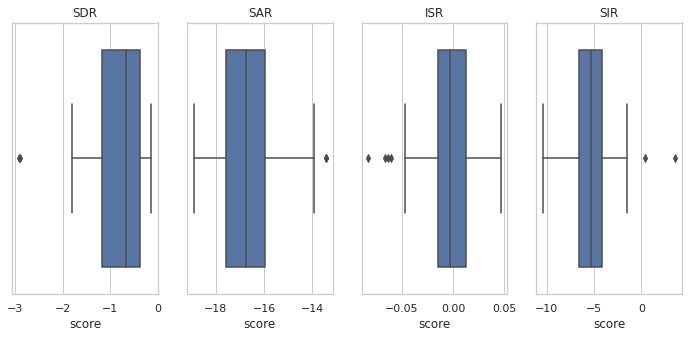

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,5))

# basic plot
# axs[0, 0].boxplot(data)
# axs[0, 0].set_title('basic plot')

ax1=sns.boxplot(x=df_sdr["score"], ax=ax[0])

ax2=sns.boxplot(x=df_sar["score"], ax=ax[1])
ax3=sns.boxplot(x=df_isr["score"], ax=ax[2])
ax4=sns.boxplot(x=df_sir["score"] , ax=ax[3])

ax1.set_title('SDR')
ax2.set_title('SAR')
ax3.set_title('ISR')
ax4.set_title('SIR')


# ax.set_title('SDR')